## Summary

---

## Imports

In [1]:
import io
import sys
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from sklearn import metrics, model_selection
from tqdm.auto import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m6nmfede because the default path (/home/p/pmkim/strokach/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
pd.set_option("max_rows", 1000)
pd.set_option("max_columns", 1000)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("45_validate_models").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/45_validate_models')

In [4]:
src_dir = str(NOTEBOOK_DIR.parents[1].joinpath("src"))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import helpers

## Load results

In [5]:
# input_file = NOTEBOOK_DIR.parent.joinpath(
#     "37_cagi6_sherloc_combine_results", "combined-results.parquet"
# )

# input_file

In [6]:
# result_df = pq.read_table(input_file).to_pandas()

# display(result_df.head(2))
# print(len(result_df))

In [7]:
# effect_map = {
#     "Uncertain significance": 0,
#     "Likely benign": -1,
#     "Benign": -2,
#     "Likely pathogenic": 1,
#     "Pathogenic": 2,
# }

# result_df["effect_score"] = result_df["effect"].map(effect_map)

In [8]:
input_file_1 = NOTEBOOK_DIR.parent.joinpath(
    "37_cagi6_sherloc_combine_results", "combined-results.parquet"
)

input_file_2 = NOTEBOOK_DIR.parent.joinpath(
    "37_humsavar_combine_results", "combined-results.parquet"
)

input_file_1, input_file_2

(PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/37_cagi6_sherloc_combine_results/combined-results.parquet'),
 PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/37_humsavar_combine_results/combined-results.parquet'))

In [9]:
result_df = pd.concat(
    [pq.read_table(input_file_1).to_pandas(), pq.read_table(input_file_2).to_pandas()],
    ignore_index=True,
)

display(result_df.head(2))
print(len(result_df))

,protein_id,mutation,mutation_id,effect,proteinsolver_core_score_wt,proteinsolver_core_features_residue_wt,proteinsolver_core_features_protein_wt,protbert_core_score_wt,protbert_core_features_residue_wt,protbert_core_features_protein_wt,msa_count_wt,msa_count_total,msa_proba_wt,msa_proba_total,msa_length,msa_proba,msa_H,msa_KL,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,rosetta_dslf_fa13_wt,rosetta_hbond_sc_wt,rosetta_hbond_bb_sc_wt,rosetta_hbond_lr_bb_wt,rosetta_hbond_sr_bb_wt,rosetta_fa_intra_elec_wt,rosetta_fa_elec_wt,rosetta_lk_ball_bridge_uncpl_wt,rosetta_lk_ball_bridge_wt,rosetta_lk_ball_iso_wt,rosetta_lk_ball_wt,rosetta_fa_intra_sol_xover4_wt,rosetta_fa_intra_rep_xover4_wt,rosetta_fa_intra_atr_xover4_wt,rosetta_fa_sol_wt,rosetta_fa_rep_wt,rosetta_fa_atr_wt,rosetta_dg_wt,rosetta_cart_bonded_change,rosetta_rama_prepro_change,rosetta_ref_change,rosetta_hxl_tors_change,rosetta_p_aa_pp_change,rosetta_fa_dun_semi_change,rosetta_fa_dun_rot_change,rosetta_fa_dun_dev_change,rosetta_omega_change,rosetta_dslf_fa13_change,rosetta_hbond_sc_change,rosetta_hbond_bb_sc_change,rosetta_hbond_lr_bb_change,rosetta_hbond_sr_bb_change,rosetta_fa_intra_elec_change,rosetta_fa_elec_change,rosetta_lk_ball_bridge_uncpl_change,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,alphafold_core_scores_residue_plddt_wt,alphafold_core_scores_protein_plddt_wt,alphafold_core_scores_protein_max_predicted_aligned_error_wt,alphafold_core_scores_proten_ptm_wt,alphafold_core_features_residue_experimentally_resolved_wt,alphafold_core_features_residue_predicted_lddt_wt,alphafold_core_features_residue_msa_first_row_wt,alphafold_core_features_residue_single_wt,alphafold_core_features_residue_structure_module_wt,alphafold_core_features_protein_experimentally_resolved_wt,alphafold_core_features_protein_predicted_lddt_wt,alphafold_core_features_protein_msa_first_row_wt,alphafold_core_features_protein_single_wt,alphafold_core_features_protein_structure_module_wt,el2_score,proteinsolver_core_score_change,proteinsolver_core_features_residue_change,proteinsolver_core_features_protein_change,protbert_core_score_change,protbert_core_features_residue_change,protbert_core_features_protein_change,msa_count_change,msa_proba_change,alphafold_core_scores_residue_plddt_change,alphafold_core_scores_protein_plddt_change,alphafold_core_scores_protein_max_predicted_aligned_error_change,alphafold_core_scores_proten_ptm_change,alphafold_core_features_residue_experimentally_resolved_change,alphafold_core_features_residue_predicted_lddt_change,alphafold_core_features_residue_msa_first_row_change,alphafold_core_features_residue_single_change,alphafold_core_features_residue_structure_module_change,alphafold_core_features_protein_experimentally_resolved_change,alphafold_core_features_protein_predicted_lddt_change,alphafold_core_features_protein_msa_first_row_change,alphafold_core_features_protein_single_change,alphafold_core_features_protein_structure_module_change,aa_wt_onehot,aa_mut_onehot
0,P26678,R9C,NM_002667.3:c.25C>T,Pathogenic,0.091593,"[0.48249053955078125, 0.24484702944755554, -0....","[-2.27313494682312, 0.6932704448699951, -0.195...",0.068529,"[0.15305250883102417, -0.11011786758899689, 0....","[0.05504663661122322, -0.04564127326011658, 0....",87.0,100.0,-0.310155,-88.633441,101.0,-0.536553,0.326639,2.625994,34.796667,18.080333,13.08,5.875333,-4.878333,33.826333,30.420,37.201667,16.900333,0.0,0.0,-0.495,0.0,-46.239,-5.748,-96.294333,-1.515667,-0.220333,-145.437333,123.757667,12.501667,9.146667,-22.659333,279.312667,18.309,-311.028667,-1.308,-0.577667,0.614667,4.553,0.021333,0.376000,0.173000,-1.592000,-0.074667,-0.012667,0.0,

282995


In [10]:
effect_map = {
    "Uncertain significance": 0,
    "US": 0,
    "Likely benign": -1,
    "Benign": -1,
    "LB/B": -1,
    "Likely pathogenic": 1,
    "Pathogenic": 1,
    "LP/P": 1,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

## Exploratory data analysis

In [11]:
result_df["effect"].value_counts()

Uncertain significance    147067
LB/B                       33125
LP/P                       21789
Likely benign              11398
Benign                      9730
US                          6265
Pathogenic                  5834
Likely pathogenic           2506
Name: effect, dtype: int64

In [12]:
result_df["effect_score"].value_counts()

 0.0    153332
-1.0     54253
 1.0     30129
Name: effect_score, dtype: int64

In [13]:
score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    "rosetta_dg_change",
    #     "alphafold_core_scores_residue_plddt_wt",
    #     "alphafold_core_scores_protein_plddt_wt",
    #     "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
    #     "alphafold_core_scores_proten_ptm_wt",
]

df = result_df.dropna(subset=score_columns + ["effect_score"])
# df = df[df["effect_score"].isin([-1, 1])].reset_index(drop=True)

for col in score_columns:
    corr = stats.spearmanr(df["effect_score"], df[col])
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    print(col, corr[0], auc)

el2_score 0.3226115042938531 0.8042752064706262
proteinsolver_core_score_change 0.1885019853014418 0.6747482856659199
protbert_core_score_change 0.2597816547260026 0.7580240751052711
rosetta_dg_change 0.17647066190927088 0.6603480777128133


## Combine

In [14]:
result_df.head(2)

,protein_id,mutation,mutation_id,effect,proteinsolver_core_score_wt,proteinsolver_core_features_residue_wt,proteinsolver_core_features_protein_wt,protbert_core_score_wt,protbert_core_features_residue_wt,protbert_core_features_protein_wt,msa_count_wt,msa_count_total,msa_proba_wt,msa_proba_total,msa_length,msa_proba,msa_H,msa_KL,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,rosetta_dslf_fa13_wt,rosetta_hbond_sc_wt,rosetta_hbond_bb_sc_wt,rosetta_hbond_lr_bb_wt,rosetta_hbond_sr_bb_wt,rosetta_fa_intra_elec_wt,rosetta_fa_elec_wt,rosetta_lk_ball_bridge_uncpl_wt,rosetta_lk_ball_bridge_wt,rosetta_lk_ball_iso_wt,rosetta_lk_ball_wt,rosetta_fa_intra_sol_xover4_wt,rosetta_fa_intra_rep_xover4_wt,rosetta_fa_intra_atr_xover4_wt,rosetta_fa_sol_wt,rosetta_fa_rep_wt,rosetta_fa_atr_wt,rosetta_dg_wt,rosetta_cart_bonded_change,rosetta_rama_prepro_change,rosetta_ref_change,rosetta_hxl_tors_change,rosetta_p_aa_pp_change,rosetta_fa_dun_semi_change,rosetta_fa_dun_rot_change,rosetta_fa_dun_dev_change,rosetta_omega_change,rosetta_dslf_fa13_change,rosetta_hbond_sc_change,rosetta_hbond_bb_sc_change,rosetta_hbond_lr_bb_change,rosetta_hbond_sr_bb_change,rosetta_fa_intra_elec_change,rosetta_fa_elec_change,rosetta_lk_ball_bridge_uncpl_change,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,alphafold_core_scores_residue_plddt_wt,alphafold_core_scores_protein_plddt_wt,alphafold_core_scores_protein_max_predicted_aligned_error_wt,alphafold_core_scores_proten_ptm_wt,alphafold_core_features_residue_experimentally_resolved_wt,alphafold_core_features_residue_predicted_lddt_wt,alphafold_core_features_residue_msa_first_row_wt,alphafold_core_features_residue_single_wt,alphafold_core_features_residue_structure_module_wt,alphafold_core_features_protein_experimentally_resolved_wt,alphafold_core_features_protein_predicted_lddt_wt,alphafold_core_features_protein_msa_first_row_wt,alphafold_core_features_protein_single_wt,alphafold_core_features_protein_structure_module_wt,el2_score,proteinsolver_core_score_change,proteinsolver_core_features_residue_change,proteinsolver_core_features_protein_change,protbert_core_score_change,protbert_core_features_residue_change,protbert_core_features_protein_change,msa_count_change,msa_proba_change,alphafold_core_scores_residue_plddt_change,alphafold_core_scores_protein_plddt_change,alphafold_core_scores_protein_max_predicted_aligned_error_change,alphafold_core_scores_proten_ptm_change,alphafold_core_features_residue_experimentally_resolved_change,alphafold_core_features_residue_predicted_lddt_change,alphafold_core_features_residue_msa_first_row_change,alphafold_core_features_residue_single_change,alphafold_core_features_residue_structure_module_change,alphafold_core_features_protein_experimentally_resolved_change,alphafold_core_features_protein_predicted_lddt_change,alphafold_core_features_protein_msa_first_row_change,alphafold_core_features_protein_single_change,alphafold_core_features_protein_structure_module_change,aa_wt_onehot,aa_mut_onehot,effect_score
0,P26678,R9C,NM_002667.3:c.25C>T,Pathogenic,0.091593,"[0.48249053955078125, 0.24484702944755554, -0....","[-2.27313494682312, 0.6932704448699951, -0.195...",0.068529,"[0.15305250883102417, -0.11011786758899689, 0....","[0.05504663661122322, -0.04564127326011658, 0....",87.0,100.0,-0.310155,-88.633441,101.0,-0.536553,0.326639,2.625994,34.796667,18.080333,13.08,5.875333,-4.878333,33.826333,30.420,37.201667,16.900333,0.0,0.0,-0.495,0.0,-46.239,-5.748,-96.294333,-1.515667,-0.220333,-145.437333,123.757667,12.501667,9.146667,-22.659333,279.312667,18.309,-311.028667,-1.308,-0.577667,0.614667,4.553,0.021333,0.376000,0.173000,-1.592000,-0.074667,-

## Load ML models and make predictions

In [15]:
def training_loop(X, y, *, weights, groups, param, n_splits=6, progressbar=False):
    models = []
    preds = np.ones(len(y), dtype=np.float64) * np.nan
    gkf = model_selection.GroupKFold(n_splits=n_splits)
    for train_index, test_index in tqdm(
        gkf.split(X, y, groups=groups),
        total=n_splits,
        disable=not progressbar,
    ):
        X_training, X_testing = X[train_index], X[test_index]
        y_training, y_testing = y[train_index], y[test_index]
        weights_training, weights_testing = weights[train_index], weights[test_index]

        groups_training = groups.iloc[train_index]
        value_counts = groups_training.value_counts()
        group_adj = groups_training.drop_duplicates().map(value_counts)

        dtrain = lgb.Dataset(
            X_training, label=y_training, weight=weights_training, group=group_adj
        )
        model = lgb.train(param, dtrain, num_boost_round=1000)
        preds[test_index] = model.predict(X_testing)
        models.append(model)
    return models, preds

In [52]:
model_infos = [
    ("6d02ae59", "optimized"),
    ("b2d0dfb9", "optimized"),  # AFchange
    ("1855e7a4", "optimized"),
    ("a6b35daa", "optimized"),
    ("2cf623ec", "optimized"),
    ("bfda8ca8", "optimized"),
    ("b93fddbb", "optimized"),  # AFchange
    #
    #
    # `base` + `AFwt`
    #     ("7f9826be", "initial"),
    ("7f9826be", "optimized"),
    #
    # `base` + `AFwt`
    #     ("fd28687b", "initial"),
    ("fd28687b", "optimized"),
    #
    # `base` + `AFwt` + `AFmut`
    #     ("900500fe", "initial"),
    ("900500fe", "optimized"),
    #
    # `base` + `AFwt` + `AFmut`
    #     ("be3bdad5", "initial"),
    ("be3bdad5", "optimized"),
    #
    #
    #
    #
    #
    #     # `base` + `EL2` + `AFwt`
    #     #     ("6999e5aa", "initial"),
    #     ("6999e5aa", "optimized"),
    #     # `base` + `EL2` + `AFwt` + `AFmut` [no opt]
    #     #     ("4df6fd79", "initial"),
    #     # `base`
    #     #     ("0d59c727", "initial"),
    #     ("0d59c727", "optimized"),
    #     # `base - rosetta`
    #     #     ("eabf01fe", "initial"),
    #     ("eabf01fe", "optimized"),
    #     # `base - rosetta - ps`
    #     ("a7b1c747", "optimized"),
]

In [53]:
# model_infos = [
#     ("6d02ae59", "optimized"),
# ]

In [54]:
features = []
for unique_id, model_type in tqdm(model_infos):
    scalar_features, vector_features = helpers.load_features(
        NOTEBOOK_DIR.parent, unique_id
    )
    features += scalar_features + vector_features


prediction_ref_df = result_df[
    result_df["effect_score"].notnull() & (result_df["effect_score"] != 0)
]
prediction_df = (
    prediction_ref_df[prediction_ref_df[list(set(features))].notnull().all(axis=1)]
    .sort_values("protein_id")
    .copy()
)
print(
    f"Lost {len(prediction_ref_df) - len(prediction_df)} rows due to missing features."
)


Lost 67129 rows due to missing features.


In [55]:
for unique_id, model_type in tqdm(model_infos):
    scalar_features, vector_features = helpers.load_features(
        NOTEBOOK_DIR.parent, unique_id
    )
    features_to_exclude = helpers.load_features_to_exclude(
        NOTEBOOK_DIR.parent, unique_id, model_type
    )
    best_parameters = helpers.load_best_parameters(
        NOTEBOOK_DIR.parent, unique_id, model_type
    )

    X_ref = np.c_[
        prediction_df[scalar_features].values,
        np.hstack([np.vstack(prediction_df[col].values) for col in vector_features]),
    ]

    if features_to_exclude is not None:
        feature_mask = np.ones(X_ref.shape[1], dtype=bool)
        feature_mask[np.array(features_to_exclude, dtype=int)] = False
        X = X_ref[:, feature_mask]
        assert len(features_to_exclude) == X_ref.shape[1] - X.shape[1]
    else:
        X = X_ref

    low_confidence_mask = (prediction_df["effect_score"] == 0).values

    y = (prediction_df["effect_score"] > 0).values.astype(int)
    y[low_confidence_mask] = (
        prediction_df[low_confidence_mask]["el2_score"] > 2
    ).values.astype(int)
    #     y = prediction_df["effect_score"].values

    weights = np.ones(len(prediction_df), dtype=np.float64)
    weights[prediction_df["effect_score"] == 1] = 0.5
    weights[prediction_df["effect_score"] == -1] = 0.5
    weights[low_confidence_mask] = 0.05

    protein_ids = prediction_df["protein_id"]

    models, preds = training_loop(
        X,
        y,
        weights=weights,
        groups=protein_ids,
        param=best_parameters | {"objective": "binary"},
    )

    pred_column = f"pred_{unique_id}_{model_type}"
    prediction_df[pred_column] = preds

#     for model_idx, model in enumerate(models):
#         prediction_df[f"pred_{unique_id}_{model_type}_{model_idx}"] = model.predict(X)

#     prediction_df[pred_column] = prediction_df[
#         [
#             f"pred_{unique_id}_{model_type}_{model_idx}"
#             for model_idx in range(len(models))
#         ]
#     ].mean(axis=1)

In [56]:
# for bst_idx, bst in enumerate(models):
#     bst.save_model(str(NOTEBOOK_DIR.parent.joinpath("38_cagi6_sherloc_train_model", "436f9567", f"model-starting-{bst_idx}.txt")))

In [57]:
cols = [f"pred_{unique_id}_{model_type}" for unique_id, model_type in model_infos]

df = prediction_df[prediction_df["effect_score"] != 0]

model_stats = []
for col in cols:
    corr = stats.spearmanr(df["effect_score"], df[col])
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    precision = metrics.average_precision_score(df["effect_score"] > 0, df[col])
    model_stats.append((col, len(df), corr[0], auc, precision))

model_stats_df = pd.DataFrame(
    model_stats, columns=["col", "num_rows", "spearman_rho", "auc", "precision"]
)

In [58]:
np.mean([0.9, 0.9, 0.9, 0.1])

0.7000000000000001

In [59]:
np.exp(np.sum(np.log([0.9, 0.9, 0.9, 0.1])))

0.0729

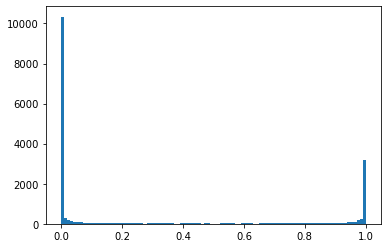

In [60]:
plt.hist(prediction_df[cols[0]], bins=100)
None

---

```csv
col	num_rows	spearman_rho	auc	precision
7	pred_be3bdad5_optimized	17253	0.660275	0.948133	0.905960
5	pred_900500fe_optimized	17253	0.661431	0.948289	0.905941
1	pred_7f9826be_optimized	17253	0.658835	0.946360	0.903161
3	pred_fd28687b_optimized	17253	0.660638	0.946663	0.902854
9	pred_6999e5aa_optimized	17253	0.656857	0.944983	0.900826
12	pred_0d59c727_optimized	17253	0.637160	0.935759	0.888277
14	pred_eabf01fe_optimized	17253	0.629048	0.930742	0.880559
```

regression_l1

```csv
col	num_rows	spearman_rho	auc	precision
3	pred_be3bdad5_optimized	17253	0.637726	0.934685	0.881122
2	pred_900500fe_optimized	17253	0.634744	0.932937	0.879540
4	pred_6999e5aa_optimized	17253	0.634151	0.932642	0.878677
0	pred_7f9826be_optimized	17253	0.632483	0.930091	0.873714
1	pred_fd28687b_optimized	17253	0.629686	0.928276	0.872713
5	pred_0d59c727_optimized	17253	0.603354	0.914350	0.855177
6	pred_eabf01fe_optimized	17253	0.608284	0.914428	0.853633
```

regression_l1 on full dataset

```csv
col	num_rows	spearman_rho	auc	precision
2	pred_900500fe_optimized	17253	0.630979	0.928408	0.876794
3	pred_be3bdad5_optimized	17253	0.624719	0.925131	0.869726
4	pred_6999e5aa_optimized	17253	0.625411	0.923101	0.868643
1	pred_fd28687b_optimized	17253	0.623880	0.923605	0.866927
0	pred_7f9826be_optimized	17253	0.619522	0.919911	0.860476
5	pred_0d59c727_optimized	17253	0.582443	0.899871	0.836196
6	pred_eabf01fe_optimized	17253	0.584318	0.900190	0.835659
```

---

In [61]:
df = model_stats_df[model_stats_df["col"].str.endswith("_optimized")].sort_values(
    "precision", ascending=False
)

df

,col,num_rows,spearman_rho,auc,precision
9,pred_900500fe_optimized,17253,0.735486,0.948219,0.906446
1,pred_b2d0dfb9_optimized,17253,0.734647,0.947708,0.905968
10,pred_be3bdad5_optimized,17253,0.734565,0.947658,0.905640
8,pred_fd28687b_optimized,17253,0.732317,0.946288,0.902621
7,pred_7f9826be_optimized,17253,0.729959,0.944851,0.900648
0,pred_6d02ae59_optimized,17253,0.728178,0.943766,0.899229
5,pred_bfda8ca8_optimized,17253,0.714831,0.935632,0.886818
3,pred_a6b35daa_optimized,17253,0.698553,0.925712,0.872866
6,pred_b93fddbb_optimized,17253,0.699024,0.925999,0.871428
4,pred_2cf623ec_optimized,17253,0.681744,0.915468,0.855581


In [62]:
descriptions = {
    "6d02ae59": "proteinsolver-protbert-rosetta_ddg-alphafold_wt",
    "b2d0dfb9": "proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change",
    "1855e7a4": "proteinsolver",
    "a6b35daa": "protbert",
    "2cf623ec": "rosetta_ddg",
    "bfda8ca8": "alphafold_wt",
    "b93fddbb": "alphafold_change",
    #
    "7f9826be": "† `base` + `AFwt",
    "fd28687b": "`base` + `AFwt",
    "900500fe": "† `base` + `AFwt` + `AFmut",
    "be3bdad5": "base` + `AFwt` + `AFmut",
}

In [63]:
df["description"] = df["col"].str.split("_").str[1].map(descriptions)

In [64]:
df

,col,num_rows,spearman_rho,auc,precision,description
9,pred_900500fe_optimized,17253,0.735486,0.948219,0.906446,† `base` + `AFwt` + `AFmut
1,pred_b2d0dfb9_optimized,17253,0.734647,0.947708,0.905968,proteinsolver-protbert-rosetta_ddg-alphafold_w...
10,pred_be3bdad5_optimized,17253,0.734565,0.947658,0.905640,base` + `AFwt` + `AFmut
8,pred_fd28687b_optimized,17253,0.732317,0.946288,0.902621,`base` + `AFwt
7,pred_7f9826be_optimized,17253,0.729959,0.944851,0.900648,† `base` + `AFwt
0,pred_6d02ae59_optimized,17253,0.728178,0.943766,0.899229,proteinsolver-protbert-rosetta_ddg-alphafold_wt
5,pred_bfda8ca8_optimized,17253,0.714831,0.935632,0.886818,alphafold_wt
3,pred_a6b35daa_optimized,17253,0.698553,0.925712,0.872866,protbert
6,pred_b93fddbb_optimized,17253,0.699024,0.925999,0.871428,alphafold_change
4,pred_2cf623ec_optimized,17253,0.681744,0.915468,0.855581,rosetta_ddg


In [65]:
print(df.to_csv(index=False))

col,num_rows,spearman_rho,auc,precision,description
pred_900500fe_optimized,17253,0.7354856043327243,0.9482191810766243,0.9064460127045698,† `base` + `AFwt` + `AFmut
pred_b2d0dfb9_optimized,17253,0.7346465855388026,0.947707866763327,0.9059681098917662,proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change
pred_be3bdad5_optimized,17253,0.7345652166112319,0.9476582789619261,0.9056403859073822,base` + `AFwt` + `AFmut
pred_fd28687b_optimized,17253,0.732317473690829,0.9462884608647142,0.9026205233330327,`base` + `AFwt
pred_7f9826be_optimized,17253,0.7299587820757071,0.944851028482742,0.9006481903084101,† `base` + `AFwt
pred_6d02ae59_optimized,17253,0.7281784682664034,0.9437660707446643,0.8992294897475985,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_bfda8ca8_optimized,17253,0.7148309423466335,0.9356318297389664,0.8868176529446166,alphafold_wt
pred_a6b35daa_optimized,17253,0.6985532259113003,0.9257118739128337,0.8728662959252519,protbert
pred_b93fddbb_optimized,17253,0.69902

In [ ]:
# With AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_900500fe_optimized,17253,0.7354856043327243,0.9482191810766243,0.9064460127045698,† `base` + `AFwt` + `AFmut
pred_b2d0dfb9_optimized,17253,0.7346465855388026,0.947707866763327,0.9059681098917662,proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change
pred_be3bdad5_optimized,17253,0.7345652166112319,0.9476582789619261,0.9056403859073822,base` + `AFwt` + `AFmut
pred_fd28687b_optimized,17253,0.732317473690829,0.9462884608647142,0.9026205233330327,`base` + `AFwt
pred_7f9826be_optimized,17253,0.7299587820757071,0.944851028482742,0.9006481903084101,† `base` + `AFwt
pred_6d02ae59_optimized,17253,0.7281784682664034,0.9437660707446643,0.8992294897475985,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_bfda8ca8_optimized,17253,0.7148309423466335,0.9356318297389664,0.8868176529446166,alphafold_wt
pred_a6b35daa_optimized,17253,0.6985532259113003,0.9257118739128337,0.8728662959252519,protbert
pred_b93fddbb_optimized,17253,0.6990239962585558,0.9259987704860353,0.8714278272872622,alphafold_change
pred_2cf623ec_optimized,17253,0.6817438107602027,0.9154678905510983,0.8555810561252877,rosetta_ddg
pred_1855e7a4_optimized,17253,0.6741823722269124,0.9108598033675988,0.8479407023908969,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

In [ ]:
# No AFchange features
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_6d02ae59_optimized,81595,0.7126101934569414,0.9302800089637497,0.880811545138274,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_7f9826be_optimized,81595,0.7124691243200059,0.9301948302362175,0.880199093804648,† `base` + `AFwt
pred_fd28687b_optimized,81595,0.7114664224991962,0.9295893904706803,0.8794599027426224,`base` + `AFwt
pred_bfda8ca8_optimized,81595,0.7030689431700953,0.9245189220506452,0.872121834543896,alphafold_wt
pred_a6b35daa_optimized,81595,0.6743788270565445,0.9071955894191768,0.845464460517332,protbert
pred_2cf623ec_optimized,81595,0.6717861214568219,0.9056300920422187,0.8439723991520722,rosetta_ddg
pred_1855e7a4_optimized,81595,0.6589128014374122,0.8978570734912574,0.8329363544743443,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

In [ ]:
text = """\
col,num_rows,spearman_rho,auc,precision,description
pred_b2d0dfb9_optimized,17253,0.6601727571431505,0.9481965731116135,0.9067716066327483,proteinsolver-protbert-rosetta_ddg-alphafold_wt-alphafold_change
pred_900500fe_optimized,17253,0.6612351121473227,0.9481366245739297,0.9066021792716579,† `base` + `AFwt` + `AFmut
pred_be3bdad5_optimized,17253,0.6602745245026902,0.9481329563941763,0.9059602464731495,base` + `AFwt` + `AFmut
pred_fd28687b_optimized,17253,0.66006825770403,0.9468243894127648,0.9030312955646863,`base` + `AFwt
pred_7f9826be_optimized,17253,0.6570532178203087,0.9449691139264764,0.9007917435348626,† `base` + `AFwt
pred_6d02ae59_optimized,17253,0.6573581105157068,0.9442761423684942,0.9001343322979737,proteinsolver-protbert-rosetta_ddg-alphafold_wt
pred_bfda8ca8_optimized,17253,0.6429108664472806,0.9352726325942174,0.885861339727888,alphafold_wt
pred_a6b35daa_optimized,17253,0.620116936734454,0.9253679932900758,0.8727568045746302,protbert
pred_b93fddbb_optimized,17253,0.6274405849607265,0.9261415450253343,0.8711723520642649,alphafold_change
pred_2cf623ec_optimized,17253,0.6081952728908755,0.9155725010488,0.8573706009222684,rosetta_ddg
pred_1855e7a4_optimized,17253,0.6030478406891615,0.9100577895518862,0.8478961125297617,proteinsolver
"""

buf = io.StringIO()
buf.write(text)
buf.seek(0)
df = pd.read_csv(buf)

df

,col,num_rows,spearman_rho,auc,precision,description
0,pred_b2d0dfb9_optimized,17253,0.660173,0.948197,0.906772,proteinsolver-protbert-rosetta_ddg-alphafold_w...
1,pred_900500fe_optimized,17253,0.661235,0.948137,0.906602,† `base` + `AFwt` + `AFmut
2,pred_be3bdad5_optimized,17253,0.660275,0.948133,0.905960,base` + `AFwt` + `AFmut
3,pred_fd28687b_optimized,17253,0.660068,0.946824,0.903031,`base` + `AFwt
4,pred_7f9826be_optimized,17253,0.657053,0.944969,0.900792,† `base` + `AFwt
5,pred_6d02ae59_optimized,17253,0.657358,0.944276,0.900134,proteinsolver-protbert-rosetta_ddg-alphafold_wt
6,pred_bfda8ca8_optimized,17253,0.642911,0.935273,0.885861,alphafold_wt
7,pred_a6b35daa_optimized,17253,0.620117,0.925368,0.872757,protbert
8,pred_b93fddbb_optimized,17253,0.627441,0.926142,0.871172,alphafold_change
9,pred_2cf623ec_optimized,17253,0.608195,0.915573,0.857371,rosetta_ddg
